# Coursera IBM Data Science Capstone Notebook

In [57]:
import pandas as pd
import numpy as np

In [58]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


# Data Import

In [59]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_b8926009f7664cfba35ac73e70d7091c = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='8niCe6DFjmLAuLsE2eiNmzBQ8d4UJpsrmGa28Z2wh1XK',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_b8926009f7664cfba35ac73e70d7091c.get_object(Bucket='capstoneproject-donotdelete-pr-erzvwftbfwpa3j',Key='Collisions Master Dataset.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)


In [60]:
df.columns

Index(['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS',
       'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC',
       'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE',
       'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE',
       'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [61]:
df['FATALITIES'].sum()

372

# Data Wrangling

## Non-valuable variables are getting dropped out of the data frame

In [62]:
df_good_attr = df.drop(columns = ['X','Y','OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO','STATUS','INTKEY','LOCATION',
                                  'EXCEPTRSNCODE', 'EXCEPTRSNDESC','SEVERITYDESC','SDOT_COLDESC','SDOTCOLNUM',
                                 'ST_COLDESC','SEGLANEKEY','CROSSWALKKEY',])
print('Shape: ',df_good_attr.shape)
df_good_attr.head()

Shape:  (221144, 23)


,ADDRTYPE,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,...,SDOT_COLCODE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,HITPARKEDCAR
0,Block,0,NaN,0,0,0,0,0,0,0,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,NaN,0,NaN,0,0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,Block,1,Left Turn,2,0,0,2,0,0,0,...,11.0,NaN,N,Overcast,Dry,Daylight,NaN,NaN,28,N
3,Block,1,Parked Car,2,0,0,2,0,0,0,...,13.0,NaN,0,Clear,Dry,Other,NaN,NaN,32,N
4,Block,1,Rear Ended,2,0,0,2,0,0,0,...,14.0,Y,0,Clear,Dry,Daylight,NaN,NaN,14,N


In [63]:
df_good_attr.dtypes

ADDRTYPE            object
SEVERITYCODE        object
COLLISIONTYPE       object
PERSONCOUNT          int64
PEDCOUNT             int64
PEDCYLCOUNT          int64
VEHCOUNT             int64
INJURIES             int64
SERIOUSINJURIES      int64
FATALITIES           int64
INCDATE             object
INCDTTM             object
JUNCTIONTYPE        object
SDOT_COLCODE       float64
INATTENTIONIND      object
UNDERINFL           object
WEATHER             object
ROADCOND            object
LIGHTCOND           object
PEDROWNOTGRNT       object
SPEEDING            object
ST_COLCODE          object
HITPARKEDCAR        object
dtype: object

## The incident dates and times are changed to Date.time objects

In [64]:
df_good_attr['INCDATE'] = pd.to_datetime(df_good_attr['INCDATE'])
df_good_attr['INCDTTM'] = pd.to_datetime(df_good_attr['INCDTTM'])

In [65]:
df_good_attr = df_good_attr[df_good_attr.SEVERITYCODE != '0']

In [66]:
import datetime
df_good_attr['MONTH'] = pd.DatetimeIndex(df_good_attr['INCDTTM']).month
df_good_attr['TIME'] = pd.DatetimeIndex(df_good_attr['INCDTTM']).time
df_good_attr['HOUR'] = pd.DatetimeIndex(df_good_attr['INCDTTM']).hour
df_good_attr['HOUR'].head()

2    15
3     0
4    16
5     9
6     1
Name: HOUR, dtype: int64

## A column for time of day is created by grouping times of incidents into 4 categories

In [67]:
def timeofday(x):
    if (x > 4) and (x <= 10):
        return 'Morning'
    elif (x > 10) and (x <= 16 ):
        return 'Daytime'
    elif (x > 16) and (x <= 22):
        return'Evening'
    elif (x > 22) or (x <= 4) :
        return 'Nighttime'

In [68]:
df_good_attr['TIMEOFDAY'] = df_good_attr['HOUR'].apply(timeofday)
df_good_attr['TIMEOFDAY'].head()

2      Daytime
3    Nighttime
4      Daytime
5      Morning
6    Nighttime
Name: TIMEOFDAY, dtype: object

## A column for seasons is created by grouping dates of incidents into 4 seasons

In [69]:
def season(x):
    if (x > 2) and (x <= 5):
        return 'Spring'
    elif (x > 5) and (x <= 8 ):
        return 'Summer'
    elif (x > 8) and (x <= 11):
        return'Fall'
    elif (x == 12) or (x <= 2 ):
        return 'Winter'

In [70]:
df_good_attr['SEASON'] = df_good_attr['MONTH'].apply(season)
df_good_attr['SEASON'].head()

2    Spring
3    Spring
4    Spring
5    Spring
6    Spring
Name: SEASON, dtype: object

## A column for the weekend is created by grouping days of the week as a weekend or weekday
### A value of 1 means it is the weekend, a value of zero means it is a weekday

In [71]:
df_good_attr['DAYOFWEEK'] = df_good_attr['INCDATE'].dt.dayofweek
df_good_attr['WEEKEND'] = df_good_attr['DAYOFWEEK'].apply(lambda x: 1 if (x>3)  else 0)

In [72]:
df_good_attr.groupby(['SEVERITYCODE'])['WEEKEND'].value_counts(normalize=True)

SEVERITYCODE  WEEKEND
1             0          0.575538
              1          0.424462
2             0          0.592432
              1          0.407568
2b            0          0.581718
              1          0.418282
3             0          0.535817
              1          0.464183
Name: WEEKEND, dtype: float64

## Dummies are created for Collision Type, Time of Day, and Season

In [73]:
df_good_attr = pd.concat([df_good_attr,pd.get_dummies(df_good_attr['COLLISIONTYPE'])], axis=1)
df_good_attr = pd.concat([df_good_attr,pd.get_dummies(df_good_attr['TIMEOFDAY'])], axis=1)
df_good_attr = pd.concat([df_good_attr,pd.get_dummies(df_good_attr['SEASON'])], axis=1)

## Weather is one-hot encoded - 1 means hazardous weather while 0 means non-hazardous

In [74]:
df_good_attr['WEATHER'].replace(to_replace=['Blowing Snow','Severe Crosswind','Blowing Sand/Dirt','Sleet/Hail/Freezing Rain',
                                            'Fog/Smog/Smoke','Snowing','Raining'], value='1',inplace=True)
df_good_attr['WEATHER'].replace(to_replace=['Clear','Overcast','Unknown','Other','Partly Cloudy'], value='0',inplace=True)

## Driver Drunkenness is one-hot encoded

In [75]:
df_good_attr['UNDERINFL'].replace(to_replace='N', value='0',inplace=True)
df_good_attr['UNDERINFL'].replace(to_replace='Y', value='1',inplace=True)

In [76]:
df_good_attr.columns

Index(['ADDRTYPE', 'SEVERITYCODE', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES',
       'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'INATTENTIONIND',
       'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT',
       'SPEEDING', 'ST_COLCODE', 'HITPARKEDCAR', 'MONTH', 'TIME', 'HOUR',
       'TIMEOFDAY', 'SEASON', 'DAYOFWEEK', 'WEEKEND', 'Angles', 'Cycles',
       'Head On', 'Left Turn', 'Other', 'Parked Car', 'Pedestrian',
       'Rear Ended', 'Right Turn', 'Sideswipe', 'Daytime', 'Evening',
       'Morning', 'Nighttime', 'Fall', 'Spring', 'Summer', 'Winter'],
      dtype='object')

## The feature set is selected

In [77]:
feature = df_good_attr[['SEVERITYCODE','UNDERINFL', 'WEATHER','WEEKEND', 'Angles', 'Cycles',
       'Head On', 'Left Turn', 'Other', 'Parked Car', 'Pedestrian',
       'Rear Ended', 'Right Turn', 'Sideswipe', 'Daytime', 'Evening',
       'Morning', 'Nighttime', 'Fall', 'Spring', 'Summer', 'Winter']]
feature[0:5]

,SEVERITYCODE,UNDERINFL,WEATHER,WEEKEND,Angles,Cycles,Head On,Left Turn,Other,Parked Car,...,Right Turn,Sideswipe,Daytime,Evening,Morning,Nighttime,Fall,Spring,Summer,Winter
2,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
5,2,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
6,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0


In [78]:
feature['UNDERINFL'].replace(to_replace='0', value=0,inplace=True)
feature['UNDERINFL'].replace(to_replace='1', value=1,inplace=True)
feature['WEATHER'].replace(to_replace='0', value=0,inplace=True)
feature['WEATHER'].replace(to_replace='1', value=1,inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [79]:
feature.isna().sum()

SEVERITYCODE       1
UNDERINFL       4765
WEATHER         4975
WEEKEND            0
Angles             0
Cycles             0
Head On            0
Left Turn          0
Other              0
Parked Car         0
Pedestrian         0
Rear Ended         0
Right Turn         0
Sideswipe          0
Daytime            0
Evening            0
Morning            0
Nighttime          0
Fall               0
Spring             0
Summer             0
Winter             0
dtype: int64

In [80]:
X1 = feature[feature['SEVERITYCODE']== '1']
X2 = feature[feature['SEVERITYCODE']== '2']
X2b = feature[feature['SEVERITYCODE']== '2b']
X3 = feature[feature['SEVERITYCODE']== '3']

## Null values are replaced by average values in the columns for the respective severity codes

In [81]:
X1.fillna(X1.mean(),inplace=True)
X2.fillna(X2.mean(),inplace=True)
X2b.fillna(X2b.mean(),inplace=True)
X3.fillna(X3.mean(),inplace=True)
print('null values are replaced with averages')

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


null values are replaced with averages


In [82]:
print('Shape of X1 df: ', X1.shape)
print('Shape of X2 df: ', X2.shape)
print('Shape of X2b df: ', X2b.shape)
print('Shape of X3 df: ', X3.shape)

Shape of X1 df:  (137414, 22)
Shape of X2 df:  (58665, 22)
Shape of X2b df:  (3096, 22)
Shape of X3 df:  (349, 22)


## The samples per severity code is changed to 10000 for each severity code

In [83]:
from sklearn.utils import resample

X3_upsampled = resample(X3, 
                                 replace=True,     # sample with replacement
                                 n_samples=10000,    # to match majority class
                                 random_state=1) # reproducible results
print(X3_upsampled['UNDERINFL'].value_counts(normalize=True))
print(X3_upsampled['WEATHER'].value_counts(normalize=True))

0.000000    0.7015
1.000000    0.2661
0.275148    0.0324
Name: UNDERINFL, dtype: float64
0.000000    0.8148
1.000000    0.1528
0.159763    0.0324
Name: WEATHER, dtype: float64


In [84]:
diff3U = X3['UNDERINFL'].value_counts(normalize=True) - X3_upsampled['UNDERINFL'].value_counts(normalize=True)
diff3W = X3['WEATHER'].value_counts(normalize=True) - X3_upsampled['WEATHER'].value_counts(normalize=True)
print(diff3U)
print(diff3W)

0.000000    0.000506
1.000000    0.000376
0.275148   -0.000881
Name: UNDERINFL, dtype: float64
0.000000   -0.001046
1.000000    0.001928
0.159763   -0.000881
Name: WEATHER, dtype: float64


In [85]:
from sklearn.utils import resample

X2b_upsampled = resample(X2b, 
                                 replace=True,     # sample with replacement
                                 n_samples=10000,    # to match majority class
                                 random_state=100) # reproducible results
print(X2b_upsampled['UNDERINFL'].value_counts(normalize=True))
print(X2b_upsampled['WEATHER'].value_counts(normalize=True))

0.000000    0.8530
1.000000    0.1328
0.135215    0.0142
Name: UNDERINFL, dtype: float64
0.000000    0.8031
1.000000    0.1804
0.178889    0.0165
Name: WEATHER, dtype: float64


In [86]:
diff2bU = X2b['UNDERINFL'].value_counts(normalize=True) - X2b_upsampled['UNDERINFL'].value_counts(normalize=True)
diff2bW = X2b['WEATHER'].value_counts(normalize=True) - X2b_upsampled['WEATHER'].value_counts(normalize=True)
print(diff2bU)
print(diff2bW)

0.000000   -0.001902
1.000000    0.000275
0.135215    0.001627
Name: UNDERINFL, dtype: float64
0.000000    0.003425
1.000000   -0.004689
0.178889    0.001265
Name: WEATHER, dtype: float64


In [87]:
from sklearn.utils import resample

X2_downsampled = resample(X2, 
                                 replace=True,     # sample with replacement
                                 n_samples=10000,    # to match majority class
                                 random_state=0) # reproducible results
print(X2_downsampled['UNDERINFL'].value_counts(normalize=True))
print(X2_downsampled['WEATHER'].value_counts(normalize=True))

0.00000    0.9234
1.00000    0.0603
0.06173    0.0163
Name: UNDERINFL, dtype: float64
0.000000    0.7848
1.000000    0.1981
0.202755    0.0171
Name: WEATHER, dtype: float64


In [88]:
diff2U = X2['UNDERINFL'].value_counts(normalize=True) - X2_downsampled['UNDERINFL'].value_counts(normalize=True)
diff2W = X2['WEATHER'].value_counts(normalize=True) - X2_downsampled['WEATHER'].value_counts(normalize=True)
print(diff2U)
print(diff2W)

0.00000   -0.000516
1.00000    0.000418
0.06173    0.000098
Name: UNDERINFL, dtype: float64
0.000000   -0.001403
1.000000    0.001133
0.202755    0.000270
Name: WEATHER, dtype: float64


In [89]:
from sklearn.utils import resample

X1_downsampled = resample(X1, 
                                 replace=True,     # sample with replacement
                                 n_samples=10000,    # to match majority class
                                 random_state=1000) # reproducible results
print(X1_downsampled['UNDERINFL'].value_counts(normalize=True))
print(X1_downsampled['WEATHER'].value_counts(normalize=True))

0.00000    0.9310
1.00000    0.0398
0.04161    0.0292
Name: UNDERINFL, dtype: float64
0.000000    0.7981
1.000000    0.1713
0.175452    0.0306
Name: WEATHER, dtype: float64


In [90]:
diff1U = X1['UNDERINFL'].value_counts(normalize=True) - X1_downsampled['UNDERINFL'].value_counts(normalize=True)
diff1W = X1['WEATHER'].value_counts(normalize=True) - X1_downsampled['WEATHER'].value_counts(normalize=True)
print(diff1U)
print(diff1W)

0.00000    0.001285
1.00000    0.000676
0.04161   -0.001961
Name: UNDERINFL, dtype: float64
0.000000    0.003107
1.000000   -0.000815
0.175452   -0.002291
Name: WEATHER, dtype: float64


In [91]:
print('Shape of X1_downsampled df: ', X1_downsampled.shape)
print('Shape of X2_downsampled df: ', X2_downsampled.shape)
print('Shape of X2b_upsampled df: ', X2b_upsampled.shape)
print('Shape of X3_upsampled df: ', X3_upsampled.shape)

Shape of X1_downsampled df:  (10000, 22)
Shape of X2_downsampled df:  (10000, 22)
Shape of X2b_upsampled df:  (10000, 22)
Shape of X3_upsampled df:  (10000, 22)


In [92]:
Fullset = pd.concat([X1_downsampled, X2_downsampled, X2b_upsampled, X3_upsampled])
Fullset['SEVERITYCODE'].value_counts()

2b    10000
2     10000
1     10000
3     10000
Name: SEVERITYCODE, dtype: int64

In [93]:
Fullset.head()

,SEVERITYCODE,UNDERINFL,WEATHER,WEEKEND,Angles,Cycles,Head On,Left Turn,Other,Parked Car,...,Right Turn,Sideswipe,Daytime,Evening,Morning,Nighttime,Fall,Spring,Summer,Winter
170059,1,0.0,0.0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
108562,1,0.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
110986,1,0.0,0.0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
216633,1,0.0,0.0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
180028,1,0.0,0.0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1


# Data Exploration

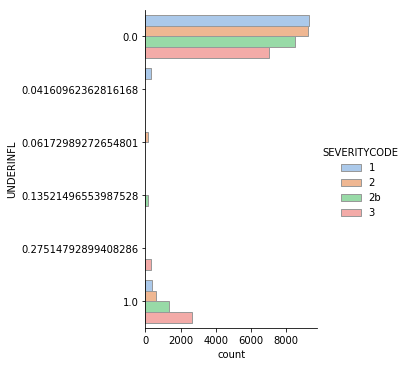

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(y="UNDERINFL", hue="SEVERITYCODE", kind="count",
            palette="pastel", edgecolor=".6",
            data=Fullset)

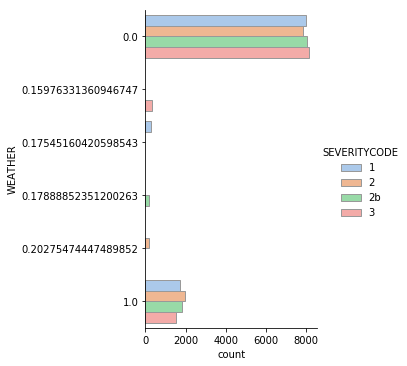

In [105]:
sns.catplot(y="WEATHER", hue="SEVERITYCODE", kind="count",
            palette="pastel", edgecolor=".6",
            data=Fullset)

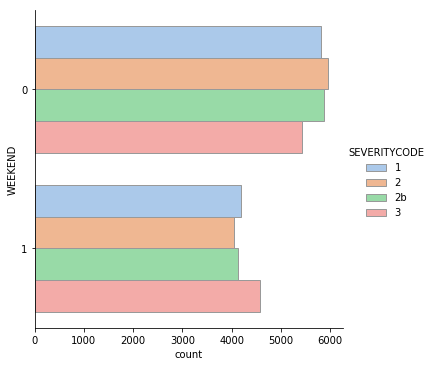

In [106]:
sns.catplot(y="WEEKEND", hue="SEVERITYCODE", kind="count",
            palette="pastel", edgecolor=".6",
            data=Fullset)

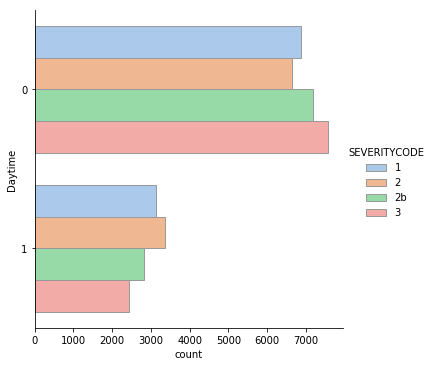

In [107]:
sns.catplot(y="Daytime", hue="SEVERITYCODE", kind="count",
            palette="pastel", edgecolor=".6",
            data=Fullset)

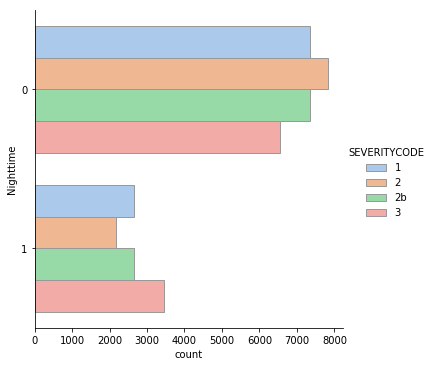

In [108]:
sns.catplot(y="Nighttime", hue="SEVERITYCODE", kind="count",
            palette="pastel", edgecolor=".6",
            data=Fullset)

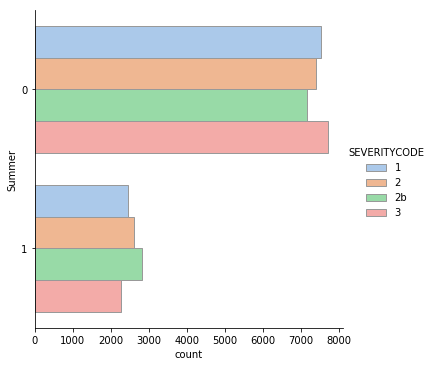

In [109]:
sns.catplot(y="Summer", hue="SEVERITYCODE", kind="count",
            palette="pastel", edgecolor=".6",
            data=Fullset)

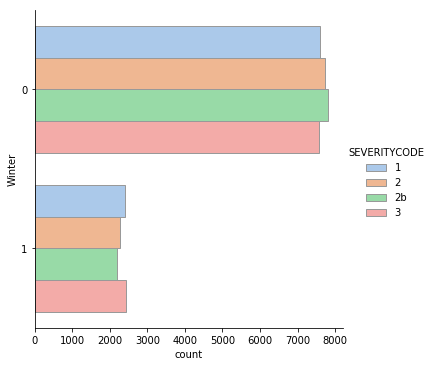

In [110]:
sns.catplot(y="Winter", hue="SEVERITYCODE", kind="count",
            palette="pastel", edgecolor=".6",
            data=Fullset)

Based on the above visualizations, it appears that time of day and driver drunkenness have the greatest impact on
differences in collision severity.

# Modeling

## Feature Selection and Pre-Processing

In [94]:
X = Fullset.drop(['SEVERITYCODE'], axis = 1)
X[0:5]

,UNDERINFL,WEATHER,WEEKEND,Angles,Cycles,Head On,Left Turn,Other,Parked Car,Pedestrian,...,Right Turn,Sideswipe,Daytime,Evening,Morning,Nighttime,Fall,Spring,Summer,Winter
170059,0.0,0.0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
108562,0.0,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
110986,0.0,0.0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
216633,0.0,0.0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
180028,0.0,0.0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [95]:
y = Fullset['SEVERITYCODE'].values
y[0:5]

array(['1', '1', '1', '1', '1'], dtype=object)

## A test/train split is created

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (32000, 21) (32000,)
Test set: (8000, 21) (8000,)


## The featured variables are normalized

In [97]:
from sklearn import preprocessing
X_train= preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_test= preprocessing.StandardScaler().fit(X_test).transform(X_test)
print(X_train[0:1])
print(X_test[0:1])

[[-0.38605651 -0.47387277  1.17205424 -0.41962059 -0.28927573 -0.17802331
   3.60530862 -0.44033647 -0.35184201 -0.48324003 -0.37780247 -0.09546495
  -0.23390864  1.54672105 -0.58432684 -0.46633754 -0.61134631 -0.59168998
  -0.58317203  1.70813574 -0.54909088]]
[[-0.39384987 -0.47445788 -0.86744706 -0.42849392 -0.2801032  -0.17396553
  -0.275141    2.21352773 -0.34456444 -0.47090031 -0.38996632 -0.09120652
  -0.234799   -0.63696809 -0.59063106  2.15724599 -0.61723338 -0.60122407
  -0.57388614 -0.57888987  1.80049481]]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


## KNN Optimization

In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neighbor = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat1=neighbor.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat1)

    
    std_acc[n-1]=np.std(yhat1==y_test)/np.sqrt(yhat1.shape[0])

mean_acc

array([0.463375, 0.435625, 0.469625, 0.473375, 0.49225 , 0.501125,
       0.508125, 0.498875, 0.501   , 0.513   , 0.519625, 0.516625,
       0.52225 , 0.52725 , 0.531   , 0.52975 , 0.5255  , 0.529125,
       0.530375])

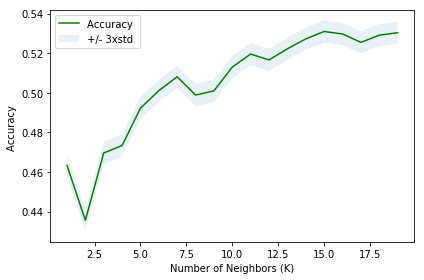

In [99]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
%matplotlib inline
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [100]:
print( "The best KNN accuracy was", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best KNN accuracy was 0.531 with k= 15


## Decision Tree Optimization

In [101]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
s = 50
mean_acc_tree = np.zeros((s))
std_acc_tree = np.zeros((s))

for n in range(1,s):
    Tree = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    yhat2=Tree.predict(X_test)
    mean_acc_tree[n-1] = metrics.accuracy_score(y_test, yhat2)
    
mean_acc_tree

array([0.340375, 0.390875, 0.43525 , 0.44375 , 0.470875, 0.483   ,
       0.51325 , 0.526875, 0.536875, 0.5445  , 0.55425 , 0.557875,
       0.5625  , 0.566125, 0.565375, 0.564875, 0.565125, 0.568   ,
       0.570625, 0.5705  , 0.57075 , 0.5705  , 0.570375, 0.57075 ,
       0.5705  , 0.570625, 0.5705  , 0.5705  , 0.570625, 0.57075 ,
       0.5705  , 0.5705  , 0.570625, 0.570625, 0.570375, 0.570625,
       0.570625, 0.57025 , 0.5705  , 0.570375, 0.5705  , 0.570625,
       0.570625, 0.570375, 0.5705  , 0.570375, 0.5705  , 0.57025 ,
       0.570625, 0.      ])

In [ ]:
print( "The best Decision Tree accuracy was", mean_acc_tree.max(), "with Max Depth =", mean_acc_tree.argmax()+1)

# Model Evaluation

In [ ]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier(n_neighbors = 15).fit(X_train,y_train)
y_KNN_predict = KNN_model.predict(X_test)

print('Jaccard Score: ',jaccard_similarity_score(y_test,y_KNN_predict))
print('F1 Score: ',f1_score(y_test,y_KNN_predict,average='weighted'))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DecTree_model = DecisionTreeClassifier(criterion="entropy", max_depth = 36).fit(X_train,y_train)
y_tree_predict=DecTree_model.predict(X_test)

print('Jaccard Score: ',jaccard_similarity_score(y_test,y_tree_predict))
print('F1 Score: ',f1_score(y_test,y_tree_predict,average='weighted'))

In [ ]:
from sklearn import svm
svm_model = svm.SVC(kernel='linear',C=0.1,gamma=0.001)
svm_model.fit(X_train, y_train)
y_svm_predict=svm_model.predict(X_test)

print('Jaccard Score: ',jaccard_similarity_score(y_test,y_svm_predict))
print('F1 Score: ',f1_score(y_test,y_svm_predict,average='weighted'))

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(C=0.1, solver='lbfgs').fit(X_train,y_train)
y_logistic_predict = logistic.predict(X_test)

print('Jaccard Score: ',jaccard_similarity_score(y_test,y_logistic_predict))
print('F1 Score: ',f1_score(y_test,y_logistic_predict,average='weighted'))

# Accuracy Results for the Models

| Algorithm          | Jaccard | F1-score |
|--------------------|---------|----------|
| KNN                | 0.5310       | 0.5262        |
| Decision Tree      | 0.5706       | 0.5628        |
| SVM                | 0.4848       | 0.4719        |
| LogisticRegression | 0.4999       | 0.4862    |

# Conclusion

The most accurate model for predicting car collision severity based on driver behavior \
and driving conditions is the *Decision Tree Algorithm* shown a few cells above. \
This algorithm can be used by the Seattle government to predict car collision severity \
and appropriately plan a budget and resources for that.